In [1]:
%load_ext autoreload
%load_ext tensorboard
%matplotlib inline

In [2]:
import matplotlib
import numpy as np
import os
import random
import yaml
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import rc
from matplotlib import cm
import seaborn as sns
from importlib import reload
from pathlib import Path
import sklearn
import joblib
import torch
import pandas as pd
import copy

# Set the font to a nicer font
rc('text', usetex=True)
plt.style.use('seaborn-whitegrid')
plt.rcParams["font.family"] = "serif"

In [3]:
def get_metric_from_dict(results, method, metric):
    vals = []
    for _, metric_keys in results.items():
        for candidate_method, metric_map in metric_keys.items():
            if method != candidate_method:
                continue
            for metric_name, val in metric_map.items():
                if metric_name == metric:
                    vals.append(val)
    return vals

def extract_param_from_name(model_name, pat):
    start_idx = model_name.find(pat) + len(pat)
    end_idx = model_name.find("_", start_idx)
    if end_idx == -1:
        return float(model_name[start_idx:])
    else:
        return float(model_name[start_idx:end_idx])

# [PREAMBLE] Standarized Colors and Markers

In [4]:
# Plot Hyperparameters
clrs = sns.color_palette("deep", 15)
MAIN_METHOD = "MixCEM Final All Sample"

color_map = {
    "Bayes MLP": "black",
    "Bayes Classifier": "black",
    "MixCEM (ours)": "red",
    "MixCEM (No Calibration)": "gray",
    "MixCEM (no IntCEM loss)": "black",
    "MixCEM + IntCEM": "orange",
    "MixIntCEM (ours)": "orange",
    "IntCEM": "cyan",
    "Logit Joint CBM": "salmon",
    "Independent CBM": "lightgreen",
    "Sequential CBM": "slateblue",
}

baselines_to_include = [
    "Joint CBM",
    "Hybrid-CBM",
    "CEM",
    # "Sigmoidal CEM",
    "IntCEM",
    "ProbCBM",
    "Posthoc CBM",
    "Posthoc Hybrid CBM",
    "Entropy CMCMixCEM",
    "Bayes MLP",
    "Sequential CBM",
    "Independent CBM",
    "Logit Joint CBM",
]
for idx, baseline in enumerate(baselines_to_include):
    if baseline not in color_map:
        color_map[baseline] = clrs[idx]

markers = {
    "Joint CBM": '-o',
    "Vanilla CBM": '-o',
    "Sigmoidal Joint CBM": '-o',
    "Logit Joint CBM": '-v',
    "Sequential CBM": '-^',
    "Independent CBM": '-2',
    "Hybrid-CBM": '-v',
    "Hybrid CBM": '-v',
    "CEM": '-^',
    "IntCEM": '-x',
    "ProbCBM": '-s',
    "Posthoc CBM": '-p',
    "P-CBM": '-p',
    "Posthoc Hybrid CBM": '-1',
    "Hybrid Posthoc CBM": '-1',
    "Hybrid P-CBM": '-1',
    "MixCEM (ours)": '--*',
    "MixCEM (No Calibration)": ':*',
    "MixCEM (no IntCEM loss)": ":*",
    "MixCEM + IntCEM": ":*",
    "MixIntCEM (ours)": ":*",
    "Bayes MLP": ":.",
    "Bayes Classifier": ":.",
}

max_limit = 10

select_metric = 'val_acc_y_random_group_level_True_use_prior_False_int_auc'

rename_map = {
    "Entropy CMCMixIntCEM": "MixIntCEM (ours)",
    "Entropy CMCMixCEM": "MixCEM (ours)",
    MAIN_METHOD: "MixCEM (ours)",
    "MixCEM Final": "MixCEM (ours)",
    "MixCEM Final All": "MixCEM (ours)",
    "Entropy CMCMixIntCEM No Calibration": "MixIntCEM (No Calibration)",
    "Entropy CMCMixCEM No Calibration": "MixCEM (No Calibration)",
    "MixCEM Final No Calibration": "MixCEM (No Calibration)",
    "Posthoc Hybrid CBM": "Residual P-CBM",
    "Hybrid Posthoc CBM": "Residual P-CBM",
    "Posthoc CBM": "P-CBM",
    "Bayes MLP": "Bayes Classifier",
    "Joint CBM": "Vanilla CBM",
    "Hybrid-CBM": "Hybrid CBM",
}
used_rename_map = rename_map
show_variance = True
ood_suffix = 'OOD_sap_0.1_'

# Training Times Comparisons

In [5]:
from texttable import Texttable
import latextable
from collections import defaultdict

results_to_include = [
    dict(
        path='/anfs/bigdisc/me466/mixcem_results/cub_complete/',
        name='\\texttt{CUB}',
    ),
    dict(
        path='/anfs/bigdisc/me466/mixcem_results/cub_incomplete/',
        name='\\texttt{CUB-Incomplete}',
        rename={'Posthoc Hybrid CBM': 'Hybrid Posthoc CBM'},
    ),
    dict(
        path='/anfs/bigdisc/me466/mixcem_results/awa2_complete/',
        name='\\texttt{AwA2}',
    ),
    dict(
        path='/anfs/bigdisc/me466/mixcem_results/awa2_incomplete/',
        name='\\texttt{AwA2-Incomplete}',
    ),
    dict(
        path='/anfs/bigdisc/me466/mixcem_results/cifar10/',
        name='\\texttt{Cifar10}',
    ),
    dict(
        path='/anfs/bigdisc/me466/mixcem_results/celeba/',
        name='\\texttt{CelebA}',
    ),
]

for res in results_to_include:
    print(res['name'])
    res['results'] = joblib.load(os.path.join(res['path'], 'results.joblib'))

latex_table = Texttable()
baselines_to_include = [
    # "DNN",
    # "Joint CBM",
    # "Hybrid-CBM",
    # "Sigmoidal CEM",
    "ProbCBM",
    # "Posthoc CBM",
    # "Posthoc Hybrid CBM",
    "CEM",
    "IntCEM",
    "Entropy CMCMixCEM No Calibration",  # Using this as otherwise it we would accidentally just count calibration training time!
]
num_stds = 2
select_metric = 'val_acc_y_random_group_level_True_use_prior_False_int_auc'
cols = ["Method"] + [x['name'] for x in results_to_include]
rows = []
metrics_to_include = [('training_time', 'black')]
col_results =  [defaultdict(list) for _ in metrics_to_include]
best_col_results = [defaultdict(lambda: (float("inf"), None)) for _ in metrics_to_include]

for idx, label in enumerate(baselines_to_include):
    new_row = []
    for col, dataset_results in enumerate(results_to_include):
        real_label = dataset_results.get('rename', {}).get(label, label)
        used_select_metric = dataset_results.get(
            'select_metric',
            select_metric,
        )
        dataset_results['selected_models'] = joblib.load(os.path.join(dataset_results['path'], f'selected_models_{used_select_metric}.joblib'))
        selected_models = dataset_results['selected_models']
        model_name = selected_models.get(
            real_label + " (Baseline)",
            real_label + " (Baseline)",
        )
        results = dataset_results['results']
        metric_vals = []
        for metric_idx, (metric, color) in enumerate(metrics_to_include):
            metric_val = np.array(get_metric_from_dict(
                results,
                model_name,
                metric,
            ))
            num_epochs = np.array(get_metric_from_dict(
                results,
                model_name,
                'num_epochs',
            ))
            metric_val = metric_val / num_epochs
            used_name = rename_map.get(label, label)
            if len(new_row) == 0:
                new_row.append(used_name)
            mean = np.mean(metric_val, axis=0)
            std = np.std(metric_val, axis=0)
            if mean < best_col_results[metric_idx][col][0]:
                best_col_results[metric_idx][col] = (mean, std)
            col_results[metric_idx][col].append((mean, std))
    rows.append(new_row)

for idx, label in enumerate(baselines_to_include):
    new_row = rows[idx]
    for col, dataset_results in enumerate(results_to_include):
        entry = '$'
        for metric_idx, (metric, color) in enumerate(metrics_to_include):
            mean, std = col_results[metric_idx][col][idx]
            if metric_idx:
                entry += " \; / \;"
            if "DNN" in label and metric == "test_auc_c":
                # Then this is not applicable
                entry += " \\textcolor{gray}{\\text{N/A \; \; \; \; \;}} "
            else:
                if mean + num_stds * std <= (best_col_results[metric_idx][col][0] - num_stds * best_col_results[metric_idx][col][1]):
                    entry += (f" \\textcolor{{{color}}}{{\\underline{{{mean:.2f}_{{\pm {std:.2f}}}}}}}")
                else:
                    entry += (f" \\textcolor{{{color}}}{{{mean:.2f}_{{\pm {std:.2f}}}}}")
        new_row.append(entry + "$")

latex_table.set_cols_align(["c" for _ in cols])
latex_table.set_cols_valign(["m" for _ in cols])
latex_table.add_rows([cols] + rows)
print('-- Example 1: Basic --')
print('Texttable Output:')
print(latex_table.draw())
print('\nLatextable Output:')
print(
    latextable.draw_latex(
        latex_table,
        caption=(
            "Task Accuracy results"
        ),
        caption_above=True,
        label="tab:task_accuracy_summary",
        position="ht",
        use_booktabs=True,
))


\texttt{CUB}
\texttt{CUB-Incomplete}
\texttt{AwA2}
\texttt{AwA2-Incomplete}
\texttt{Cifar10}
\texttt{CelebA}
-- Example 1: Basic --
Texttable Output:
+-----------+-----------+----------+----------+----------+----------+----------+
|  Method   | \texttt{C | \texttt{ | \texttt{ | \texttt{ | \texttt{ | \texttt{ |
|           |    UB}    | CUB-Inco |  AwA2}   | AwA2-Inc | Cifar10} | CelebA}  |
|           |           | mplete}  |          | omplete} |          |          |
+===========+===========+==========+==========+==========+==========+==========+
|           | $ \textco | $ \textc | $ \textc | $ \textc | $ \textc | $ \textc |
|           | lor{black | olor{bla | olor{bla | olor{bla | olor{bla | olor{bla |
|  ProbCBM  | }{67.90_{ | ck}{26.0 | ck}{182. | ck}{121. | ck}{428. | ck}{11.1 |
|           |    \pm    |  8_{\pm  | 38_{\pm  | 07_{\pm  | 52_{\pm  |  4_{\pm  |
|           |  6.54}}$  | 2.67}}$  | 6.09}}$  | 25.12}}$ | 156.10}} | 0.12}}$  |
|           |           |          |    

In [127]:
from texttable import Texttable
import latextable
from collections import defaultdict

dataset_results = dict(
    path='/anfs/bigdisc/me466/mixcem_results/cub_incomplete_smaller_ablation/',
    name='\\texttt{CUB-Incomplete}',
)
select_metric = 'val_acc_y_random_group_level_True_use_prior_False_int_auc'
dataset_results['results'] = joblib.load(os.path.join(dataset_results['path'], 'results.joblib'))
dataset_results['selected_models'] = joblib.load(os.path.join(dataset_results['path'], f'selected_models_{select_metric}.joblib'))

latex_table = Texttable()
baselines_to_include = [
    "Base IntCEM",
    "Base MixCEM"
]
used_rename_map = {
    "Base IntCEM": "IntCEM",
    "Base MixCEM": "MixCEM (ours)",
}
num_stds = 2
metrics_to_include = [('training_time', 'Training Time (min)', None, 'min'), ('num_epochs', 'Epochs to Convergence', None, 'min'), ('sec_per_epoch', 'Seconds per Epoch', None, 'min')]
cols = [""] + [name for (_, name, _, _) in metrics_to_include]
rows = []
col_results =  defaultdict(list)
best_col_results = defaultdict(lambda: (float("inf"), None))

for idx, label in enumerate(baselines_to_include):
    new_row = []
    selected_models = dataset_results['selected_models']
    model_name = selected_models.get(
        label,
        label,
    )
    results = dataset_results['results']
    metric_vals = []
    for col, (metric, col_name, color, mode) in enumerate(metrics_to_include):
        if metric == 'sec_per_epoch':
            metric_val = np.array(get_metric_from_dict(
                results,
                model_name,
                'training_time',
            ))
            num_epochs = np.array(get_metric_from_dict(
                results,
                model_name,
                'num_epochs',
            ))
            metric_val = metric_val / num_epochs
        elif metric == 'training_time':
            metric_val = np.array(get_metric_from_dict(
                results,
                model_name,
                metric,
            )) / 60
        else:
            metric_val = np.array(get_metric_from_dict(
                results,
                model_name,
                metric,
            ))
        used_name = used_rename_map.get(label, label)
        if len(new_row) == 0:
            new_row.append(used_name)
        mean = np.mean(metric_val, axis=0)
        std = np.std(metric_val, axis=0)
        if mode == 'min':
            if mean < best_col_results[col][0]:
                best_col_results[col] = (mean, std)
        else:
            if mean > best_col_results[col][0]:
                best_col_results[col] = (mean, std)
        col_results[col].append((mean, std))
    rows.append(new_row)

for idx, label in enumerate(baselines_to_include):
    new_row = rows[idx]
    for col, (metric, col_name, color, mode) in enumerate(metrics_to_include):
        entry = '$'
        mean, std = col_results[col][idx]
        if mode == 'max':
            if mean + num_stds * std >= (best_col_results[col][0] - num_stds * best_col_results[col][1]):
                if color is not None:
                    entry += (f" \\textcolor{{{color}}}{{\\underline{{{mean:.2f}_{{\pm {std:.2f}}}}}}}")
                else:
                    entry += (f" \\underline{{{mean:.2f}_{{\pm {std:.2f}}}}}")
            else:
                if color is not None:
                    entry += (f" \\textcolor{{{color}}}{{{mean:.2f}_{{\pm {std:.2f}}}}}")
                else:
                    entry += (f" {mean:.2f}_{{\pm {std:.2f}}}")
        else:
            if mean + num_stds * std <= (best_col_results[col][0] - num_stds * best_col_results[col][1]):
                if color is not None:
                    entry += (f" \\textcolor{{{color}}}{{\\underline{{{mean:.2f}_{{\pm {std:.2f}}}}}}}")
                else:
                    entry += (f" \\underline{{{mean:.2f}_{{\pm {std:.2f}}}}}")
            else:
                if color is not None:
                    entry += (f" \\textcolor{{{color}}}{{{mean:.2f}_{{\pm {std:.2f}}}}}")
                else:
                    entry += (f" {mean:.2f}_{{\pm {std:.2f}}}")
        new_row.append(entry + "$")

latex_table.set_cols_align(["c" for _ in cols])
latex_table.set_cols_valign(["m" for _ in cols])
latex_table.add_rows([cols] + rows)
print(latex_table.draw())
print('\nLatextable Output:')
print(
    latextable.draw_latex(
        latex_table,
        caption=(
            "Training ablation"
        ),
        caption_above=True,
        label="tab:training_times",
        position="ht",
        use_booktabs=True,
))


+---------------+--------------------+--------------------+--------------------+
|               |   Training Time    |     Epochs to      | Seconds per Epoch  |
|               |       (min)        |    Convergence     |                    |
+===============+====================+====================+====================+
|    IntCEM     |    $ 31.66_{\pm    |   $ 115.00_{\pm    |    $ 16.54_{\pm    |
|               |       3.87}$       |      15.00}$       |       0.14}$       |
+---------------+--------------------+--------------------+--------------------+
| MixCEM (ours) | $ \underline{3.77_ | $ \underline{30.00 | $ \underline{7.54_ |
|               |    {\pm 0.00}}$    |   _{\pm 0.00}}$    |    {\pm 0.00}}$    |
+---------------+--------------------+--------------------+--------------------+

Latextable Output:
\begin{table}[ht]
	\caption{Training ablation}
	\begin{center}
		\begin{tabular}{cccc}
			\toprule
			 & Training Time (min) & Epochs to Convergence & Seconds per Epoch \

# Ablation Utils

In [19]:
selected_model = 't_1_r_1_concat_None_0_mpc_1_tmc_1_emc_50_cwc_False_ce_30_g_ood_0.1_emb_16_True_tip_0.25_itd_1_iw_0_cwl_1'

def plot_ablation_results(
    pat,
    var_name,
    filter_str,
    red_pat=selected_model,
    fig_size=(25, 4),
):
    ab_markers = [
        '-o',
        '-v',
        '-^',
        '-s',
        '-x',
        '-p',
        '-1',
        '-2',
        '-*',
        '-.',
    ]
    fig, axs = plt.subplots(
        1,
        6,
        figsize=fig_size,
        squeeze=False,
        gridspec_kw={'width_ratios': [1.5, 1.5, 1, 1, 1, 1]}
    )
    if isinstance(filter_str, str):
        models_to_include = sorted(
            [
                x for x in results['0'].keys()
                if (filter_str in x)
            ],
            key=lambda x: extract_param_from_name(x, pat),
        )
    else:
        models_to_include = sorted(
            [
                x for x in results['0'].keys()
                if np.all([subpat in x for subpat in filter_str])
            ],
            key=lambda x: extract_param_from_name(x, pat),
        )
    ab_clrs = sns.color_palette("colorblind", len(models_to_include))
    std_scale = 1

    # First plot the ID and OOD accuracies
    for col, (mode_name, mode_key) in enumerate([
        ("Baseline", " (Baseline)"),
        ("Baseline OOD", " (Baseline)"),
    ]):
        ax = axs[0, col]
        for idx, model_name in enumerate(models_to_include):
            label = "MixCEM"
            ints = np.array(get_metric_from_dict(
                results,
                model_name,
                f"{ood_suffix if 'OOD' in mode_name else ''}test_acc_y_random_group_level_True_use_prior_False_ints",
            ))
            if len(ints) == 0:
                print("Skipping", model_name, "as we could not find any results...")
                continue
            label = rename_map.get(label, label)
            means = np.mean(ints, axis=0) * 100
            stds = np.std(ints, axis=0) * 100
            color = color_map.get(model_name, ab_clrs[idx])
            marker = markers.get(model_name, ab_markers[idx])
            if red_pat in model_name:
                marker = '--*'
                color = 'red'
                label = r"$\textbf{" + label + r"}$"
            xticks = (
                [0] + list(100 * np.arange(1.0/(len(means) - 1), 1, 1.0/(len(means) - 1)))
            )
            # Make sure the label uses the correct parameter
            if col == 1:
                hp = extract_param_from_name(model_name, pat)
                if red_pat in model_name:
                    label = label + r' $\mathbf{(' + var_name + ' = ' + str(hp) + r'})$'
                else:
                    label = label + r' ($' + var_name + ' = ' + str(hp) + '$)'
            else:
                label = None
            if len(means) > max_limit:
                # Then let's only plot half the points to avoid clutter
                # Make the line first
                ax.plot(
                    xticks,
                    means,
                    marker[:-1],
                    color=color,
                    label=label,
                    markersize=8,
                )
                # Then make all the points
                ax.plot(
                    xticks[::4],
                    means[::4],
                    marker[-1:],
                    color=color,
                    label=label,
                    markersize=8,
                )
            else:
                # Otherwise, plot all points
                ax.plot(
                    xticks,
                    means,
                    marker,
                    color=color,
                    label=label,
                    markersize=8,
                )

            # print(mode_name, label, "means =", means)
            if show_variance:
                ax.fill_between(
                    xticks,
                    means - std_scale * stds,
                    means + std_scale * stds,
                    alpha=0.1,
                    facecolor=color,
                )
        ax.set_xlim(-5, 105)
        if col == 0:
            ax.set_ylabel("Task Accuracy (\%)", fontsize=22)
        if col == 0:
            ax.set_title("ID", fontsize=22)
        else:
            ax.set_title("OOD (Noise $\lambda_l = 10\%$)", fontsize=22)

        ax.set_xlabel("Intervened Concepts (\%)", fontsize=22)
        ax.xaxis.set_tick_params(labelsize=15)
        ax.yaxis.set_tick_params(labelsize=15)
        ax.grid(False)
        handles, labels = ax.get_legend_handles_labels()


    # Plot the ID task accuracy when all concepts are intervened
    ax = axs[0, 2]
    plot_colors = []
    plot_labels = []
    y_acc_plot_means = []
    y_acc_plot_stds = []
    hatches = []
    for idx, model_name in enumerate(models_to_include):
        label = "MixCEM"
        y_accs = np.array(get_metric_from_dict(
            results,
            model_name,
            f"test_acc_y_random_group_level_True_use_prior_False_ints",
        ))[:, -1]
        mean = np.mean(y_accs, axis=0) * 100
        std = np.std(y_accs, axis=0) * 100
        color = color_map.get(model_name, ab_clrs[idx])
        if red_pat in model_name:
            color = 'red'
            hatches.append('/')
        else:
            hatches.append(None)

        hp = extract_param_from_name(model_name, pat)
        if red_pat in model_name:
            label = r'$\mathbf{' + str(hp) + r'}$'
        else:
            label = f'${hp}$'
        plot_colors.append(color)
        plot_labels.append(label)
        y_acc_plot_means.append(mean)
        y_acc_plot_stds.append(std)

    ax.set_ylim(60, 100)
    ax.bar(
        range(len(y_acc_plot_means)),
        y_acc_plot_means,
        zorder=1,
        yerr=std_scale * np.array(y_acc_plot_stds),
        tick_label=plot_labels,
        color=plot_colors,
        hatch=hatches,
    )
    ax.set_ylabel("All Intervened Acc (\%)", fontsize=22)
    ax.set_title("ID", fontsize=22)

    ax.set_xlabel("$" + var_name + "$", fontsize=22)
    ax.xaxis.set_tick_params(labelsize=15)
    ax.yaxis.set_tick_params(labelsize=15)
    ax.grid(False)


    # Plot the OOD task accuracy when all concepts are intervened
    ax = axs[0, 3]
    y_acc_plot_means = []
    y_acc_plot_stds = []
    for idx, model_name in enumerate(models_to_include):
        y_accs = np.array(get_metric_from_dict(
            results,
            model_name,
            f"{ood_suffix}test_acc_y_random_group_level_True_use_prior_False_ints",
        ))[:, -1]
        mean = np.mean(y_accs, axis=0) * 100
        std = np.std(y_accs, axis=0) * 100
        y_acc_plot_means.append(mean)
        y_acc_plot_stds.append(std)

    ax.set_ylim(60, 100)
    ax.bar(
        range(len(y_acc_plot_means)),
        y_acc_plot_means,
        zorder=1,
        yerr=std_scale * np.array(y_acc_plot_stds),
        tick_label=plot_labels,
        color=plot_colors,
        hatch=hatches,
    )
    ax.set_ylabel("All Intervened Acc (\%)", fontsize=22)
    ax.set_title("OOD", fontsize=22)

    ax.set_xlabel("$" + var_name + "$", fontsize=22)
    ax.xaxis.set_tick_params(labelsize=15)
    ax.yaxis.set_tick_params(labelsize=15)
    ax.grid(False)


    # Next plot the the unintervened task accuracy
    ax = axs[0, 4]
    y_acc_plot_means = []
    y_acc_plot_stds = []
    for idx, model_name in enumerate(models_to_include):
        y_accs = np.array(get_metric_from_dict(
            results,
            model_name,
            f"test_acc_y",
        ))
        mean = np.mean(y_accs, axis=0) * 100
        std = np.std(y_accs, axis=0) * 100
        y_acc_plot_means.append(mean)
        y_acc_plot_stds.append(std)

    ax.set_ylim(50, 100)
    ax.bar(
        range(len(y_acc_plot_means)),
        y_acc_plot_means,
        zorder=1,
        yerr=std_scale * np.array(y_acc_plot_stds),
        tick_label=plot_labels,
        color=plot_colors,
        hatch=hatches,
    )
    ax.set_ylabel("Task Accuracy (\%)", fontsize=22)
    ax.set_title("ID", fontsize=22)

    ax.set_xlabel("$" + var_name + "$", fontsize=22)
    ax.xaxis.set_tick_params(labelsize=15)
    ax.yaxis.set_tick_params(labelsize=15)
    ax.grid(False)


    # Finally, plot the concept AUC
    ax = axs[0, 5]
    c_auc_plot_means = []
    c_auc_plot_stds = []
    for idx, model_name in enumerate(models_to_include):
        c_aucs = np.array(get_metric_from_dict(
            results,
            model_name,
            f"test_auc_c",
        ))
        mean = np.mean(c_aucs, axis=0) * 100
        std = np.std(c_aucs, axis=0) * 100
        c_auc_plot_means.append(mean)
        c_auc_plot_stds.append(std)

    ax.set_ylim(60, 100)
    ax.bar(
        range(len(c_auc_plot_means)),
        c_auc_plot_means,
        zorder=1,
        yerr=std_scale * np.array(c_auc_plot_stds),
        tick_label=plot_labels,
        color=plot_colors,
        hatch=hatches,
    )
    ax.set_ylabel("Mean Concept AUC (\%)", fontsize=22)
    ax.set_title("ID", fontsize=22)

    ax.set_xlabel("$" + var_name + "$", fontsize=22)
    ax.xaxis.set_tick_params(labelsize=15)
    ax.yaxis.set_tick_params(labelsize=15)
    ax.grid(False)
    lgd = fig.legend(
        handles,
        labels,
        fontsize=15,
        loc='lower center',
        bbox_to_anchor=(0.5,-0.1),
        ncol=len(models_to_include),
        markerscale=2,
    )

## Concept Weight Loss Ablation

In [7]:
!python ../experiments/run_experiments.py -c /homes/me466/cem/experiments/configs/mixcem_cub_incomplete_smaller_ablation.yaml --summary_table_metrics num_trainable_params "# Params" --summary_table_metrics OOD_sap_0.1_test_acc_y_random_group_level_True_use_prior_False_ints_100% "OOD (sap 0.1) 100% Int Acc" --fast_run --no_new_runs

INFO:root:Results will be dumped in /anfs/bigdisc/me466/mixcem_results/cub_incomplete_smaller_ablation/
Global seed set to 42
INFO:root:Setting log level to: "INFO"
[TRIAL 1/2 BEGINS AT 29/01/2025 at 09:42:59
INFO:root:		[IMPORTANT] We found previous results for run base_IntCEM_emb_size_16_intervention_weight_1_intervention_task_discount_1.1_Baseline_cwl_1 at trial 1 and WILL use them without verifying all expected evaluation keys are present as we are running in FAST RUN mode.
********** Results in between trial 1 **********
	 ******************************
+---------------------------------------------------------------------------------------------+-----------------+------------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+------------------+----------------------------+
|                                            Method                                           |  Task Accuracy  | Concept Accura

In [8]:
ablation_study = dict(
    path='/anfs/bigdisc/me466/mixcem_results/cub_incomplete_smaller_ablation/',
    name='CUB-Incomplete',
    n_concepts=112,
    n_groups=28,
)
ablation_study['results'] = joblib.load(
    os.path.join(ablation_study['path'], 'results.joblib')
)
results = ablation_study['results']


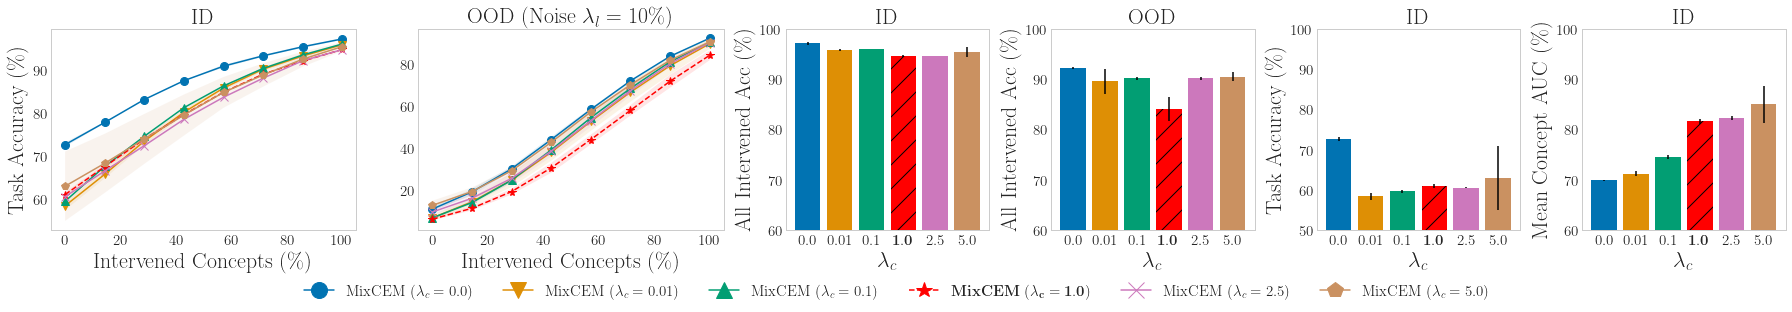

In [20]:
plot_ablation_results(
    pat="_cwl_",
    var_name=r"\lambda_c",
    fig_size=(25, 4),
    filter_str=["cwl_ab_", "_emc_50_"],
)
plt.tight_layout()
plt.savefig("../figures/ablation_concept_weight.pdf", bbox_inches='tight')
plt.savefig("../figures/ablation_concept_weight.png", bbox_inches='tight')
plt.savefig("../figures/paper/ablation_concept_weight.png", bbox_inches='tight')
plt.savefig("../figures/paper/ablation_concept_weight.pdf", bbox_inches='tight')
plt.show()

## Dropout Probability Ablation

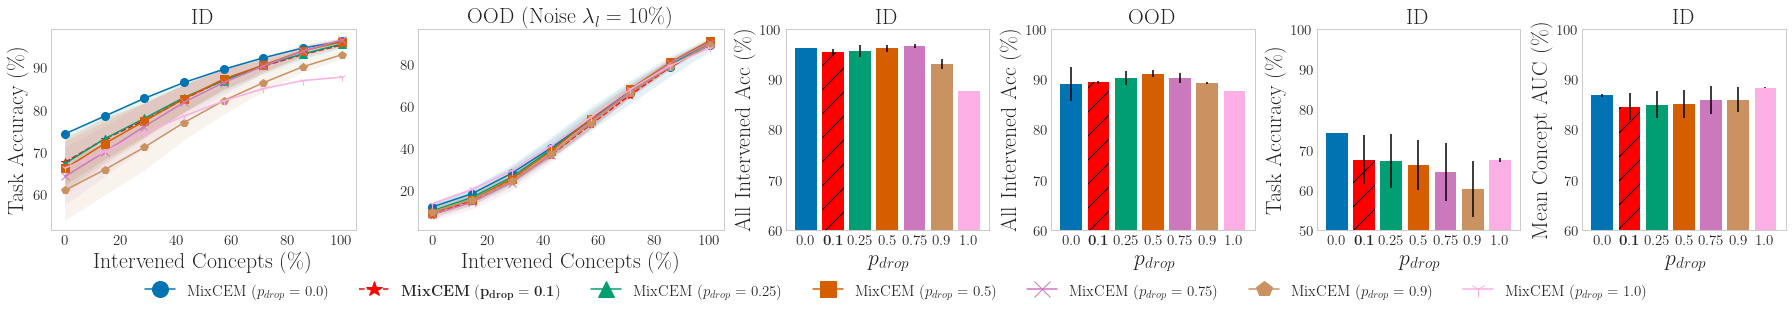

In [18]:
plot_ablation_results(
    pat="_ood_",
    var_name=r"p_{drop}",
    fig_size=(25, 4),
    filter_str=["ood_dropout_prob_ab_", "emc_50"],
)
plt.tight_layout()
plt.savefig("../figures/ablation_dropout_prob.pdf", bbox_inches='tight')
plt.savefig("../figures/ablation_dropout_prob.png", bbox_inches='tight')
plt.savefig("../figures/paper/ablation_dropout_prob.png", bbox_inches='tight')
plt.savefig("../figures/paper/ablation_dropout_prob.pdf", bbox_inches='tight')
plt.show()

## Prior Accuracy Weight Ablation

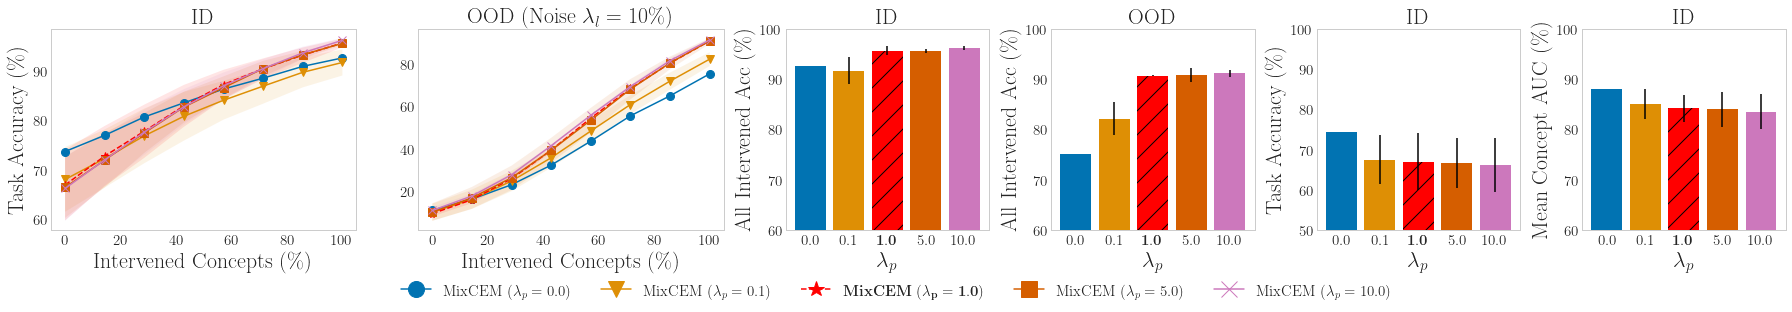

In [124]:
plot_ablation_results(
    pat="_r_",
    var_name=r"\lambda_p",
    fig_size=(25, 4),
    filter_str="all_intervened_loss_weight_ab_",
)
plt.tight_layout()
plt.savefig("../figures/ablation_prior_loss_weight.pdf", bbox_inches='tight')
plt.savefig("../figures/ablation_prior_loss_weight.png", bbox_inches='tight')
plt.savefig("../figures/paper/ablation_prior_loss_weight.png", bbox_inches='tight')
plt.savefig("../figures/paper/ablation_prior_loss_weight.pdf", bbox_inches='tight')
plt.show()

## RandInt Ablation

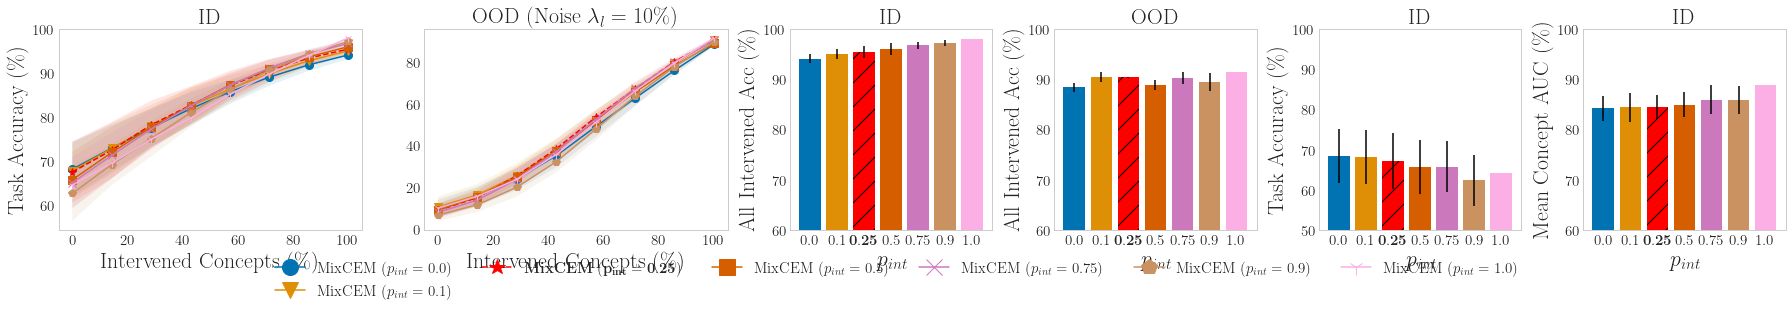

In [125]:
plot_ablation_results(
    pat="_tip_",
    var_name=r"p_{int}",
    fig_size=(25, 4),
    filter_str="training_intervention_prob_ab_",
)
plt.tight_layout()
plt.savefig("../figures/ablation_randint.pdf", bbox_inches='tight')
plt.savefig("../figures/ablation_randint.png", bbox_inches='tight')
plt.savefig("../figures/paper/ablation_randint.png", bbox_inches='tight')
plt.savefig("../figures/paper/ablation_randint.pdf", bbox_inches='tight')
plt.show()